In [4]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
import string
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'abcd')

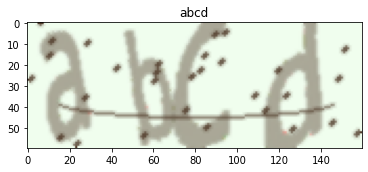

In [5]:
characters = string.digits + string.ascii_uppercase
width, height, n_len, n_class = 160, 60, 4, len(characters)
generator = ImageCaptcha(width=width, height=height)

label = 'abcd'
image = generator.generate_image(label)
plt.imshow(image)
plt.title(label)

In [6]:
numpy_image = np.array(image)

In [18]:
# construct a basic network
from keras.models import *
from keras.layers import *

HEIGHT = 60
WIDTH = 160
n_class = len(characters)

inputs = Input((HEIGHT, WIDTH, 3))
x = inputs

for i in range(3):
    x = Conv2D(32*2**i, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(32*2**i, (3, 3))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)

# train four classifiers
outputs = [Dense(n_class, activation='softmax', name='c%d' %
                 (i+1))(x) for i in range(4)]

model = Model(inputs=inputs, outputs=outputs)

In [14]:
# load data generated by generate.ipynb
images = glob.glob('images/*.jpg')

X = []
y = []

for image in images:
    X.append(cv2.imread(image))
    y.append([characters.find(ch) for ch in image[-8:-4]])

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

In [20]:
from keras.utils import to_categorical

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = list(to_categorical(y_train, num_classes=n_class).transpose(1, 0, 2))
y_test = list(to_categorical(y_test, num_classes=n_class).transpose(1, 0, 2))

In [22]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

BATCH_SIZE = 32
EPOCHS = 20
#train and save model
model_checkpoint = ModelCheckpoint(
    'models/model.h5', save_best_only=True, save_weights_only=True)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-4),
              metrics=['accuracy'])

model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(X_test, y_test),
          shuffle=True,
          callbacks=[model_checkpoint])

Train on 7972 samples, validate on 1993 samples
Epoch 1/20
7972/7972 [==============================] - 11s 1ms/step - loss: 14.2758 - c1_loss: 3.5720 - c2_loss: 3.5912 - c3_loss: 3.6072 - c4_loss: 3.5055 - c1_acc: 0.0686 - c2_acc: 0.0606 - c3_acc: 0.0592 - c4_acc: 0.0780 - val_loss: 13.8860 - val_c1_loss: 3.4398 - val_c2_loss: 3.5453 - val_c3_loss: 3.5060 - val_c4_loss: 3.3950 - val_c1_acc: 0.0718 - val_c2_acc: 0.0667 - val_c3_acc: 0.0627 - val_c4_acc: 0.0883
Epoch 2/20
7972/7972 [==============================] - 9s 1ms/step - loss: 11.8175 - c1_loss: 2.9136 - c2_loss: 3.0651 - c3_loss: 3.0891 - c4_loss: 2.7497 - c1_acc: 0.1936 - c2_acc: 0.1586 - c3_acc: 0.1553 - c4_acc: 0.2391 - val_loss: 10.8623 - val_c1_loss: 2.6275 - val_c2_loss: 2.8812 - val_c3_loss: 2.8593 - val_c4_loss: 2.4943 - val_c1_acc: 0.2549 - val_c2_acc: 0.2012 - val_c3_acc: 0.2102 - val_c4_acc: 0.2935
Epoch 3/20
7972/7972 [==============================] - 10s 1ms/step - loss: 8.7738 - c1_loss: 2.0382 - c2_loss: 2.4320

In [23]:
def decode(y):
    acc = np.cumprod(np.max(y, axis=2)[0:])[-1]
    y = np.argmax(np.array(y), axis=2)[:, 0]
    title = ''.join([characters[x] for x in y])
    return '%s %.6f' % (title, acc)

Text(0.5, 1.0, 'XIUA')

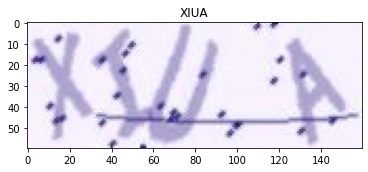

In [29]:
#generate a test sample
image = cv2.imread(images[0])
label = images[0][-8:-4]

plt.imshow(image)
plt.title(label)

In [ ]:
#if you don't wanna train,you can use trained model

#model.load_weights('models/model.h5')

Text(0.5, 1.0, 'true: XIUA\npred: XIUA 0.454909')

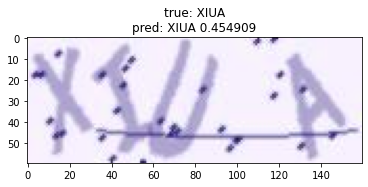

In [30]:
y_pred = model.predict(np.expand_dims(image, axis=0))
plt.imshow(image, cmap='gray')
plt.title('true: %s\npred: %s' % (label, decode(y_pred)))

In [31]:
import keras
import keras.backend as K

sess = K.get_session()
epsilon = 4.0

# func for generating adv example（fgsm）

def generate_adversarial(model, image):
    pred = np.argmax(model.predict(np.array(image)), axis=2)[:, 0]
    target = K.one_hot(pred, n_class)
    loss = K.categorical_crossentropy(model.output, target)
    gradients = K.gradients(loss, model.input)
    sign = K.sign(gradients[0])

    noise = epsilon * sign
    noise = sess.run(noise, feed_dict={model.input: image})
    adversarial = np.clip(image + noise, 0., 255.).astype(np.uint8)

    return adversarial

In [32]:
adversarial = generate_adversarial(model, np.expand_dims(image, axis=0))

Text(0.5, 1.0, 'adversarial:\n77PM 0.678882')

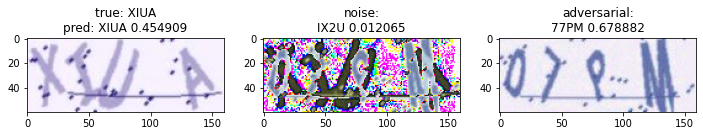

In [45]:
# ori test sample
title_original = 'true: %s\npred: %s' % (
    label, decode(model.predict(np.expand_dims(image, axis=0))))
# perturbation
title_noise = 'noise:\n%s' % decode(model.predict(adversarial - image))
# adv example related to ori test sample
title_adversarial = 'adversarial:\n%s' % decode(model.predict(adversarial))

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title(title_original)
plt.subplot(1, 3, 2)
plt.imshow(adversarial[0] - image, cmap='gray')
plt.title(title_noise)
plt.subplot(1, 3, 3)
plt.imshow(adversarial[0], cmap='gray')
plt.title(title_adversarial)

In [36]:
from tqdm import tqdm

In [37]:
#  acc under normal
acc = 0
for i in tqdm(range(100)):
    y_pred = model.predict(np.expand_dims(X[i], axis=0))
    y_pred = np.argmax(y_pred, axis=2).T[0]
    acc += np.amin(list(map(np.array_equal, y[i], y_pred)))  # python3
acc / 100

100%|██████████| 100/100 [00:00<00:00, 415.33it/s]


0.84

In [38]:
adversarials = []

# acc under attack
acc = 0
for i in tqdm(range(100)):
    adversarial = generate_adversarial(
        model, np.expand_dims(X[i], axis=0)) 
    adversarials.append(adversarial)

    y_pred = model.predict(adversarial)
    y_pred = np.argmax(y_pred, axis=2).T[0]
    acc += np.amin(list(map(np.array_equal, y[i], y_pred)))  
acc / 100

100%|██████████| 100/100 [04:05<00:00,  2.46s/it]


0.0

# to do
above results show that out model is not robust,we can refer robust tech from adv-attack domain to amplitfy out model,like adv training.
